# Importing The Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
# Loading the Dataset
dataset = pd.read_csv("D:\BOOK\Deep_learning_book\ANN\datatset\heart_failure_clinical_records_dataset.csv")

In [4]:
# train test split
def train_test_split(dataset: pd.DataFrame, train_size, prediction_column: str):
    size = int(train_size*len(dataset))
    train_dataset = dataset.sample(size)
    test_dataset = dataset.drop(train_dataset.index, axis = 0)
    X_train = train_dataset.drop([prediction_column], axis = 1)
    y_train = train_dataset[prediction_column]
    X_test = test_dataset.drop([prediction_column], axis = 1)
    y_test = test_dataset[prediction_column]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(dataset, 0.8, 'DEATH_EVENT')

In [ ]:
# Data AUGMENTATION
smote = SMOTE(random_state = 42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# Removing the skewness
skewed_columns = ['creatinine_phosphokinase', 'platelets','serum_creatinine','serum_sodium']

# Store lambdas for each column
lambdas_dict = {}

# Apply Box-Cox on training data
for col in skewed_columns:
    # Box-Cox requires positive values
    X_train[col] = X_train[col] + 1e-6
    X_train[col], lambdas_dict[col] = boxcox(X_train[col])

# Apply the same transformation to test data using the stored lambdas
for col in skewed_columns:
    X_test[col] = X_test[col] + 1e-6
    X_test[col] = boxcox(X_test[col], lmbda=lambdas_dict[col])

In [ ]:
# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Custom Class and Data Loader creation

class HeartFailureDataset(Dataset):
    def __init__(self, X, y):
        """
        X: pandas DataFrame or numpy array of features
        y: pandas Series or numpy array of labels
        """
        self.X = torch.tensor(X.values, dtype=torch.float32) if hasattr(X, 'values') else torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32) if hasattr(y, 'values') else torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = HeartFailureDataset(X_train, y_train)
test_dataset = HeartFailureDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1000, shuffle = False)

In [ ]:
# Creating the ANN Model

class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(12,128)
        self.fc2 = nn.Linear(128,60)
        self.fc3 = nn.Linear(60,1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
model = ANNModel().to("cuda")

In [ ]:
# Initialization of parameters for training
criterian = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=5,  # Reduce LR every 5 epochs
    gamma=0.5     # Multiply LR by 0.5 each time
)
epochs = 20

In [ ]:
def evaluate(test_loader):
    with torch.no_grad():
        test_loss_add = 0.0
        test_true = []
        test_predictions = []
        for test_data, test_label in test_loader:
            test_data, test_label = test_data.to("cuda"), test_label.to("cuda")
            test_pred = model(test_data)
            test_pred = test_pred.squeeze(1)
            test_loss = criterian(test_pred, test_label)
            test_true.append(test_label.cpu().numpy())
            test_predictions.append(test_pred.cpu().numpy())
            test_loss_add += test_loss.item()

        average_test_loss = test_loss_add/ len(test_loader)
        ty_true = np.concatenate(test_true)
        ty_pred = np.concatenate(test_predictions)
        ty_pred_class = (ty_pred > 0.5).astype(int)
        test_accuracy = accuracy_score(ty_true, ty_pred_class)
    return test_accuracy, average_test_loss
    
def train(input_loader: DataLoader, num_epoch: int):
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    for epoch in range(num_epoch):
        train_loss = 0.0
        true_label = []
        pred_label = []
        model.train()
        for data, label in input_loader:
            model.zero_grad()
            data, label = data.to("cuda"), label.to("cuda")
            pred_train = model(data)
            loss = criterian(pred_train.squeeze(1), label)
            loss.backward()
            optimizer.step()

            true_label.append(label.cpu().numpy())
            pred_label.append(pred_train.squeeze(1).cpu().detach().numpy())
            train_loss += loss.item()
        scheduler.step()
        y_true = np.concatenate(true_label)
        y_pred = np.concatenate(pred_label)
        y_pred_class = (y_pred > 0.5).astype(int)

        accuracy = accuracy_score(y_true, y_pred_class)
        average_loss = train_loss/len(train_loader)
        test_accuracy, test_loss = evaluate(test_loader)
        train_losses.append(average_loss)
        train_accuracies.append(accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f' Epoch {epoch + 1}: Train Loss: {average_loss}, Train Accracy: {accuracy}, Test Accuracy: {test_accuracy}, test loss: {test_loss} ')
    return train_losses, train_accuracies, test_losses, test_accuracies

In [15]:
train_losses, train_accuracies, test_losses, test_accuracies = train(train_loader, epochs)

 Epoch 1: Train Loss: 0.6272452572981516, Train Accracy: 0.7360248447204969, Test Accuracy: 0.7666666666666667, test loss: 0.6376738548278809 
 Epoch 2: Train Loss: 0.5808766086896261, Train Accracy: 0.7639751552795031, Test Accuracy: 0.8333333333333334, test loss: 0.6010121703147888 
 Epoch 3: Train Loss: 0.5487609306971232, Train Accracy: 0.7981366459627329, Test Accuracy: 0.8833333333333333, test loss: 0.5497042536735535 
 Epoch 4: Train Loss: 0.48796917994817096, Train Accracy: 0.8322981366459627, Test Accuracy: 0.8666666666666667, test loss: 0.5023321509361267 
 Epoch 5: Train Loss: 0.4497062861919403, Train Accracy: 0.8385093167701864, Test Accuracy: 0.8666666666666667, test loss: 0.4881749153137207 
 Epoch 6: Train Loss: 0.4240299438436826, Train Accracy: 0.8354037267080745, Test Accuracy: 0.8666666666666667, test loss: 0.47405701875686646 
 Epoch 7: Train Loss: 0.4357541153828303, Train Accracy: 0.8322981366459627, Test Accuracy: 0.8666666666666667, test loss: 0.461367756128311

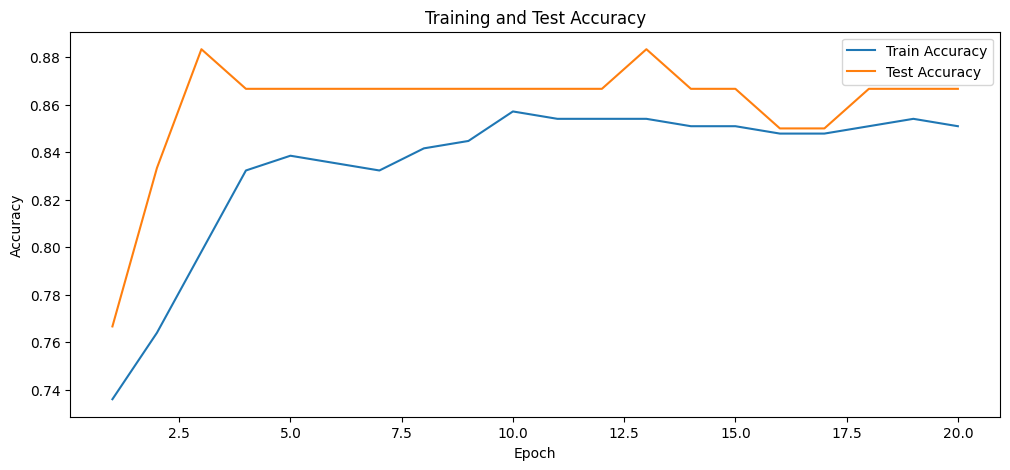

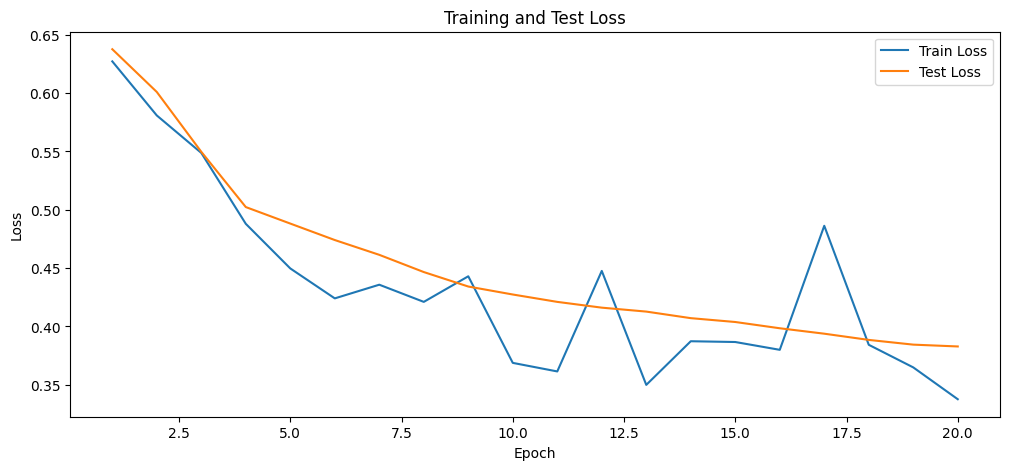

In [16]:
# Plotting Accuracy
plt.figure(figsize=(12,5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Plotting Loss
plt.figure(figsize=(12,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()